In [1]:
import numpy as np
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path

from ids_research.preprocessors import CicFlowMeterPreprocessor

In [2]:
cic_ids_2017 = pl.read_parquet(Path("~/data/CIC-IDS-2017_GeneratedLabelledFlows.parquet").expanduser())
mawi2011_01 = pl.read_parquet(Path("~/data/cicflowmeter_sample_2011-01_n3_000_000.parquet").expanduser())
mawi2016_01 = pl.read_parquet(Path("~/data/cicflowmeter_sample_2016-01_n3_000_000.parquet").expanduser())
mawi2021_01 = pl.read_parquet(Path("~/data/cicflowmeter_sample_2021-01_n3_000_000.parquet").expanduser())

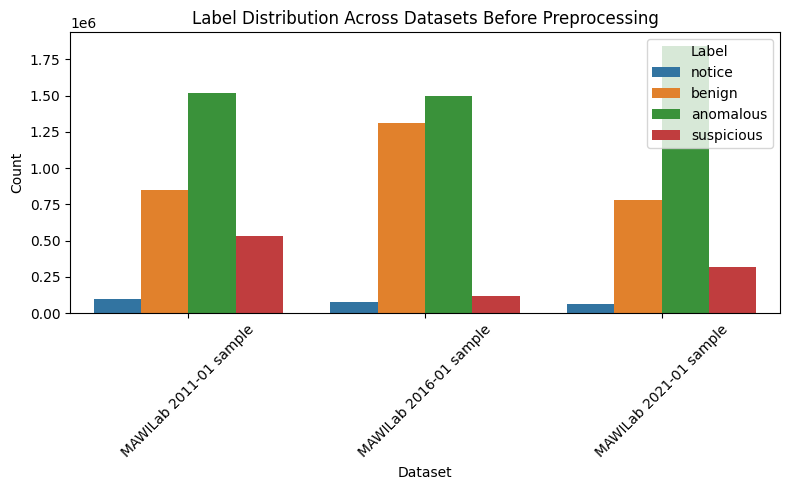

In [3]:
def label_counts(df, name):
    return (
        df.select(pl.col("Label").value_counts())
          .unnest("Label")
          .with_columns([
              pl.col("Label"),
              pl.lit(name).alias("source")
          ])
    )


counts_df = pl.concat([
    label_counts(mawi2011_01, "MAWILab 2011-01 sample"),
    label_counts(mawi2016_01, "MAWILab 2016-01 sample"),
    label_counts(mawi2021_01, "MAWILab 2021-01 sample"),
]).to_pandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=counts_df, x="source", y="count", hue="Label")
plt.title("Label Distribution Across Datasets Before Preprocessing")
plt.ylabel("Count")
plt.xlabel("Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
%time cic_ids_2017_transformed = CicFlowMeterPreprocessor().fit_transform(cic_ids_2017)

CPU times: user 9.31 s, sys: 3.73 s, total: 13 s
Wall time: 1.38 s


In [5]:
%time mawi2011_01_transformed = CicFlowMeterPreprocessor().fit_transform(mawi2011_01)

CPU times: user 10.6 s, sys: 2.79 s, total: 13.4 s
Wall time: 1.37 s


In [6]:
%time mawi2016_01_transformed = CicFlowMeterPreprocessor().fit_transform(mawi2016_01)

CPU times: user 11.2 s, sys: 2.65 s, total: 13.8 s
Wall time: 1.37 s


In [7]:
%time mawi2021_01_transformed = CicFlowMeterPreprocessor().fit_transform(mawi2021_01)

CPU times: user 13.7 s, sys: 3.5 s, total: 17.2 s
Wall time: 1.56 s


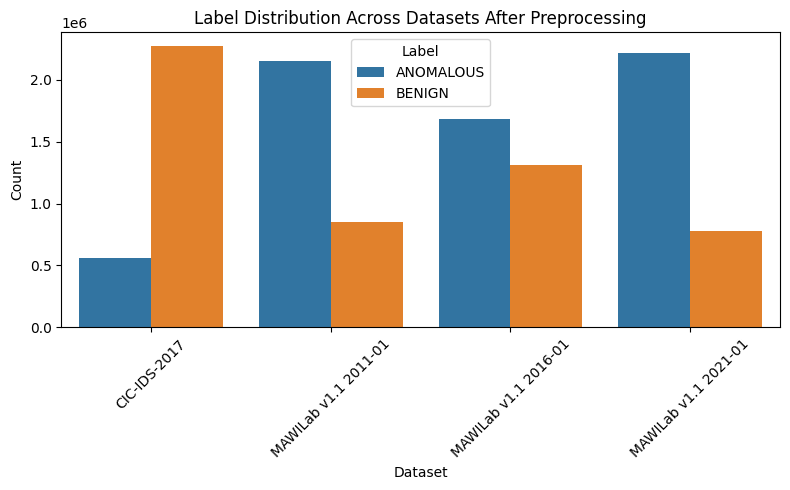

In [8]:
def label_counts(df, name):
    return (
        df.select(pl.col("Label").value_counts())
          .unnest("Label")
          .with_columns([
              pl.when(pl.col("Label") == True).then(pl.lit("ANOMALOUS"))
               .when(pl.col("Label") == False).then(pl.lit("BENIGN"))
               .otherwise(pl.col("Label"))
               .alias("Label"),
              pl.lit(name).alias("source")
          ])
    )


counts_df = pl.concat([
    label_counts(cic_ids_2017_transformed, "CIC-IDS-2017"),
    label_counts(mawi2011_01_transformed, "MAWILab v1.1 2011-01"),
    label_counts(mawi2016_01_transformed, "MAWILab v1.1 2016-01"),
    label_counts(mawi2021_01_transformed, "MAWILab v1.1 2021-01"),
]).to_pandas()

plt.figure(figsize=(8, 5))
sns.barplot(data=counts_df, x="source", y="count", hue="Label")
plt.title("Label Distribution Across Datasets After Preprocessing")
plt.ylabel("Count")
plt.xlabel("Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
label_counts = counts_df.pivot(index="source", columns="Label", values="count").rename(
    columns={
        "ANOMALOUS": "Anomalous",
        "BENIGN": "Benign"
    }
)
label_counts.index.name = "Dataset"
label_counts.to_csv("results/label_counts.csv")
label_counts.style.format('{:,}')

Label,Anomalous,Benign
Dataset,,
CIC-IDS-2017,"556,556","2,271,320"
MAWILab v1.1 2011-01,"2,151,044","848,956"
MAWILab v1.1 2016-01,"1,687,095","1,312,905"
MAWILab v1.1 2021-01,"2,220,182","779,666"
